# Qiskit Scalability Testing 

## General headers

In [14]:
# !pip install qiskit
import numpy as np
import matplotlib.pyplot as plt
from math import floor, pi, sqrt
from time import process_time
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit import Gate


## Helper Functions

In [2]:
def get_bitstring_permutations(index, lst, n, args):
    """
    This function populates a list with all the combinations of bit strings of length n
    """
    if (index == n):
        # append combination to list
        lst.append(list.copy(args))
    else:
        # handle the case where the preceding bit is 0
        args[index] = 0
        get_bitstring_permutations(index + 1, lst, n, args)

        # handle the case where the preceding bit is 1
        args[index] = 1
        get_bitstring_permutations(index + 1, lst, n, args)

def generate_uf(f, n):
    """
    Parameters: f is an anonymous function and n is the number of bits in input: f:{0,1}^n -> {0,1}^n
    This function returns an oracle gate representing the function f for all x in {0,1}^n and y in {0,1}^n,
    the desired result is of the oracle is mapping the input x,y> to |x, y + f(x)> where + is addition modulo 2.
    The function first finds the list of bitstring permutations of n bits, it then establishes a mapping which is
    representative of the decimal number of the bitstring represents. For each |x,y>, it calculates
    |x, y + f(x)>. Finally it constructs a permutation gate which treats each permutation as a different basis vector
    in the 2^(n+1) dimensional complex Hilbert space that represents a system of 2*n qubits.
    Returns: the permutation gate
    """
    # generate list of all bitstrings of size n
    bitstrings = []
    get_bitstring_permutations(0, bitstrings, n + 1, [0] * (n + 1))

    # initialize mapping and permutation list
    perm_dict = dict()
    perm_list = []

    # populate mapping
    for permutation, bitstring in enumerate(bitstrings):
        values = [0] * (len(bitstrings))
        values[permutation] = 1
        perm_dict["".join(str(bit) for bit in bitstring)] = values

    # Send each |xy> to |x, f(x) + y>
    for bitstring in bitstrings:
        params = bitstring[:n]
        params.append((f(params) + bitstring[-1]) % 2)
        perm_list.append(perm_dict["".join(str(bit) for bit in params)])
    return Operator(np.array(perm_list))

def apply_H(circuit, apply_to_list):
    """
    Apply Hadamards to all specified qubits (if apply_to_list[index] == 1).
    Designed for a large amount of Hadamards being applied at once.
    """
    for index, qubit in enumerate(apply_to_list):
        if qubit == 1:
            circuit.h(index)
    return circuit

def initialize_dj(n):
    """
    This function sets initial states and applies Hadamards to each qubit
    Note: apply_H isn't called because it is actually more efficient to initialize in one loop as opposed to 2.
    """
    # apply H to first n qubits and X H to the last qubit (ancilla qubit)
    quantum_register = QuantumRegister(n + 1)
    classical_register = ClassicalRegister(n)
    quantum_circuit = QuantumCircuit(quantum_register, classical_register)
    # In qiskit, all quantum registers start in the low energy |0> state so we must apply an x gate to our helper bit
    # in order to put it in the state |1>
    quantum_circuit.x(quantum_register[-1])
    for index in range(n + 1):
        quantum_circuit.h(quantum_register[index])
    quantum_circuit.barrier()
    return quantum_circuit, quantum_register, classical_register

def initialize_bv(states):
    """
    This function sets initial states and applies Hadamards to each qubit
    Note: apply_H isn't called because it is actually more efficient to initialize in one loop as opposed to 2.
    """
    n = len(states)
    circuit = QuantumCircuit(n, n-1)
    for index, state in enumerate(states):
        if state == 1:
            circuit.x(index)
        circuit.h(index)
    return circuit




## Deutsch Jozsa Algorithm

In [3]:
def deutsch_jozsa_algorithm(f, n, shots=1024, threshold=0.9):
    """
    This function is intended to determine if f is constant or balanced for a given function f s.t.
        f:{0,1}^n -> {0,1}. The algorithm initializes the qubits with H for the first n qubits and X and H for the last
        qubit. The algorithm then constructs a Uf oracle gate based on the function input f. It then applies Uf to all
        the qubits and applies H to the first n qubits. Finally, the simulator is run on the circuit and measures the
        results. If upon measurement, the first n qubits are all 0, 1 is returned and the function is constant,
        otherwise 0 is returned and the function is balanced.
    This function has an anonymous function and integer n as parameters.
    This function uses 9q-squared-qvm, so it assumes that n <= 9.
    """
    # apply H to first n qubits and X H to the last qubit (ancilla qubit)
    quantum_circuit, quantum_register, classical_register = initialize_dj(n)

    # Generate Uf oracle from f (anonymous function)
    uf_gate = generate_uf(f, n)
    # Applying the uf_gate must be done with the qubits in the reverse order due to the implementation of qiskit
    rv_qr = list()
    for index in range(n + 1):
        rv_qr.append(index)
    rv_qr.reverse()
    quantum_circuit.unitary(uf_gate, rv_qr)
    quantum_circuit.barrier()

    # Apply Hadamards to first n qubits
    for index in range(n):
        quantum_circuit.h(quantum_register[index])

    # Run simulator
    quantum_simulator = Aer.get_backend('qasm_simulator')
    quantum_circuit.measure(quantum_register[0:n], classical_register)
    # quantum_circuit.draw('mpl')
    # plt.show()

    # Evaluate the job results
#     start = process_time()
    job = execute(quantum_circuit, quantum_simulator, shots=shots)
#     end = process_time()
#     total_time = end - start
    results = job.result()
    counts = results.get_counts(quantum_circuit)

    # NOTE: 1 = constant, 0 = balanced
    # To compensate for the error rates of actual quantum machines, the threshold for being consider balanced is
    # set to be threshold * shots, or a percentage of shots given at runtime.

    # Function is constant
    key = '0' * n
    if key in counts:
        if counts[key] >= threshold * shots:
            return 1
    key = '1' * n
    if key in counts:
        if counts[key] >= threshold * shots:
            return 1

    # Function is balanced
    return 0

### Running the algorithm
Sample functions:

In [4]:
def f_balanced(args):
    return args[0]

def f_constant(args):
    return 1

input_size = 11

#### Evaluating Runtime
Balanced:

[0.015854000000000035, 0.005192000000000974, 0.0061989999999996215, 0.008514000000000799, 0.020997000000000376, 0.046950999999999965, 0.17492899999999967, 0.5230120000000005, 2.31294, 13.958708000000001, 98.195615]


([<matplotlib.axis.XTick at 0x116f3df28>,
 <a list of 11 Text major ticklabel objects>)

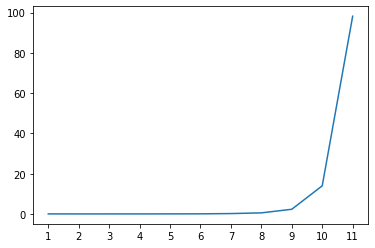

In [5]:
times = []
for i in range(1,input_size+1):
    start = process_time()
    res = deutsch_jozsa_algorithm(f_balanced, i, shots=1)
    times.append(process_time()-start)
print(times)
plt.plot(range(1,input_size+1), times)
plt.xticks(np.arange(1, input_size+1, step=1))

Constant:

[0.018906999999998675, 0.00792299999999102, 0.005309999999994375, 0.006535999999996989, 0.019407000000015273, 0.05139400000001615, 0.13742899999999736, 0.5257780000000025, 2.3371449999999925, 14.271650999999991, 92.26831200000001]


([<matplotlib.axis.XTick at 0x116e606a0>,
 <a list of 11 Text major ticklabel objects>)

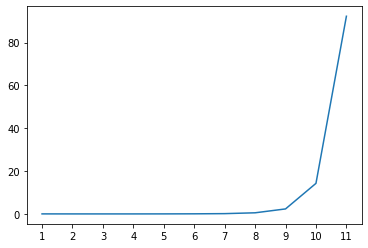

In [6]:
times = []
for i in range(1,input_size+1):
    start = process_time()
    res = deutsch_jozsa_algorithm(f_constant, i, shots=1)
    times.append(process_time()-start)
print(times)
plt.plot(range(1,input_size+1), times)
plt.xticks(np.arange(1, input_size+1, step=1))

## Bernstein Vazirani

In [7]:
def bernstein_vazirani_algorithm(f, n):
    initialize_list = [0] * n

    # calculate b by f(0^n) = b
    b = f(initialize_list)

    # Initialize circuit by applying H to first n qubits and X H to last qubit (ancilla qubit)
    initialize_list.append(1)
    qubits = list(range(len(initialize_list)))
    circuit = initialize_bv(initialize_list)

    # Generate Uf oracle from f (anonymous function)
    uf_gate = generate_uf(f, n)
    # Applying the uf_gate must be done with the qubits in the reverse order due to the implementation of qiskit
    rv_qubits = qubits[::-1]
    circuit.unitary(uf_gate, rv_qubits)

    # Apply H to all qubits except for the last qubit
    apply_to_list = [1] * n
    apply_to_list.append(0)
    circuit = apply_H(circuit, apply_to_list)
    circuit.measure(range(n),range(n))

    # run simulator and measure qubits
    simulator = Aer.get_backend("qasm_simulator")
    job = execute(circuit, simulator, shots=1)
    result = job.result()
    counts = result.get_counts(circuit)
    plot_histogram(counts)
    for count in counts:
        a = count
    return a,b

### Running the algorithm
Sample functions:

In [8]:
def f_bv(x):
    n = len(x)
    y = 0
    for i,x_i in enumerate(x):
        y = (y + (x_i*(i%2)))%2
    y = (y+(n%2))%2
    return(y)

#### Evaluating Runtime

[0.04524000000000683, 0.03967000000000098, 0.04499200000000769, 0.048734999999993533, 0.07138699999998721, 0.09288000000000807, 0.15705800000000636, 0.7450629999999876, 2.412245999999982, 13.449462000000011, 95.802956]


([<matplotlib.axis.XTick at 0x1282a2470>,
 <a list of 11 Text major ticklabel objects>)

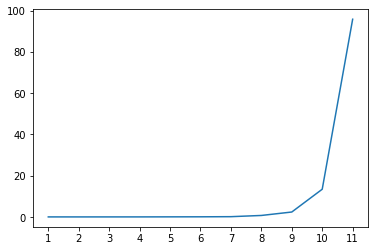

In [9]:
times = []
for i in range(1,input_size+1):
    start = process_time()
    res = bernstein_vazirani_algorithm(f_bv, i)
    times.append(process_time()-start)
print(times)
plt.plot(range(1,input_size+1), times)
plt.xticks(np.arange(1, input_size+1, step=1))

## Grovers

In [10]:
def get_Z0(n):
    """
    This function generates the Z0 gate satisfying the conditions for x in {0,1}^n Z0|x> -> -|x> iff x = 0^n
        otherwise Z0|x> -> |x>
    The parameter to this function is only the size n, a 2^n x 2^n dimensional matrix is created satisfying the
        conditions above.
    This function has one dependency, the DefGate function defined in pyquil.quil
    This function is designed to absorb the negative in G, so the returned gate is actually -Z0
    Returns -Z0
    """
    # Create a 2^n x 2^n matrix with all 0's
    gate = np.zeros((2 ** n, 2 ** n), dtype=int)
    # since this is -Z0, set first element to 1 not -1
    gate[0][0] = 1
    # set all other elements on the diagonal to -1, again not 1 because this is -Z0
    for i in range(1, 2 ** n):
        gate[i][i] = -1
    # Return gate
    return Operator(gate)


def get_Zf(f, n):
    """
    This function generates the Zf gate satisfying the condition for x in {0,1}^n where Zf|x> -> (-1)^f(X)|x>
    This function requires that f(x) be calculated for all x, so f is passed as an anonymous function, the other
        parameter is n.
    The function has one dependency, the DefGate function defined in pyquil.quil
    This function finds all permutations of bitstrings of length n, then initializes a 2^n x 2^n matrix of all 0's,
        and sets all elements along the diagonal to either 1 or -1 depending on f(x)
    Finally a gate representation of this matrix is returned.
    """
    # generate bitstring permutations
    bitstrings = list()
    get_bitstring_permutations(0, bitstrings, n, [0] * n)
    # initialize a 2^n x 2^n matrix of all 0's
    gate = np.zeros((2 ** n, 2 ** n), dtype=int)
    # set diagonals of matrix based on f(x)
    for i in range(2 ** n):
        gate[i][i] = -1 if f(bitstrings[i]) == 1 else 1
    # create and return gate
    return Operator(gate)

def grovers_algorithm(f, n, shots=1024, threshold=0.9):
    """
    This function is intended to determine if there exists an x in {0,1}^n s.t. f(x) = 1 for a given function f s.t.
        f:{0,1}^n -> {0,1}. The algorithm first constructs Zf, -Z0 gates, initializes with Hanamard matrices, and
        applies G = -H^n o Z0 o H^n o Zf. This algorithm is not deterministic, so G is applied multiple times. More
        specifically, G is run (pi / 4 * sqrt(n)) times. Furthermore, there are 10 trials to minimize the chance of a
        false negative.
    This function has an anonymous function and integer n as parameters.
    This function runs the algorithm as described for each 10 trials, and then checks if for any of the outputted states
        x, if f(x) = 1. If this is true, then 1 is returned, otherwise 0 is returned. The function returns 0 if there
        is an issue with the simulator.
    This function uses 9q-squared-qvm, so it assumes that n <= 9
    """
    # Initialize the circuit and apply Hadamards to all qubits
    quantum_circuit, quantum_register, classical_register = initialize_dj(n)

    # Needed for application of custom gates since Operator works in reverse
    rv_qr = list()
    for index in range(n):
        rv_qr.append(index)
    rv_qr.reverse()

    # Define and generate Z0 gate (really -Z0)
    z0_gate = get_Z0(n)

    # Define and generate Zf gate
    zf_gate = get_Zf(f, n)

    # Determine the number of times to apply G
    iteration_count = floor(pi / 4 * sqrt(2 ** n))
    # Apply G iteration_count times
    for i in range(iteration_count):
        # Apply Zf
        quantum_circuit.unitary(zf_gate, rv_qr)
        # Apply H to all qubits
        for index in range(n):
            quantum_circuit.h(quantum_register[index])
        # Apply -Z0
        quantum_circuit.unitary(z0_gate, rv_qr)
        # Apply H to all qubits
        for index in range(n):
            quantum_circuit.h(quantum_register[index])
        quantum_circuit.barrier()

    # Run simulator
    quantum_simulator = Aer.get_backend('qasm_simulator')
    quantum_circuit.measure(quantum_register[0:n], classical_register)

    # Display circuit diagram
    quantum_circuit.draw('mpl')
    plt.show()

    # Execute and evaluate the job results
    job = execute(quantum_circuit, quantum_simulator, shots=shots)
    results = job.result()
    counts = results.get_counts(quantum_circuit)
    return counts

    # Parse results and return 1 or 0 accordingly
#    dict = {}
#     for key in counts:
#         if counts[key] >= (shots/(2**n)):
#            dict[key] = counts[key]
#     for key in dict:
#         poop = list(key)
#         poop = [int(i) for i in poop]
#         poop.reverse()
#         if f(poop) == 1:
#             return 1
#     return 0



### Running the algorithm
Sample functions:

In [11]:
def f_0(args):
    return 0

def f_1(args):
    return 1

def f_100(args):
    n = len(args)
    marked = [0]*(n-1)
    marked.append(1)
    if(args == marked):
        return 1
    return 0

#### Evaluating Runtime
f_0:

In [ ]:
input_size = 8
times = []
for i in range(1,input_size+1):
    start = process_time()
    res = grovers_algorithm(f_0, i, shots=1024, threshold=0.9)
    times.append(process_time()-start)
print(times)
plt.plot(range(1,input_size+1), times)
plt.xticks(np.arange(1, input_size+1, step=1))

f_1:

In [ ]:
times = []
for i in range(1,input_size+1):
    start = process_time()
    res = grovers_algorithm(f_1, i, shots=1024, threshold=0.9)
    times.append(process_time()-start)
print(times)
plt.plot(range(1,input_size+1), times)
plt.xticks(np.arange(1, input_size+1, step=1))

f_100:

In [ ]:
times = []
for i in range(1,input_size+1):
    start = process_time()
    res = grovers_algorithm(f_100, i, shots=1024, threshold=0.9)
    times.append(process_time()-start)
print(times)
plt.plot(range(1,input_size+1), times)
plt.xticks(np.arange(1, input_size+1, step=1))